# Classificação das imagens de algodão

## Importando os pacotes e funções

In [2]:

#pacotes padroes
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import randint

#importando funções do sklearn
from sklearn import svm
from sklearn.metrics import accuracy_score, PredictionErrorDisplay, RocCurveDisplay, auc
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import r2_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
#from sklearn.metrics import roc_curve, auc
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

# visualizaçao das arvores
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

#tunando o modelo
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt import load
from skopt.callbacks import CheckpointSaver

#from sklearn.metrics import plot_roc_curve
import mpl_toolkits.mplot3d.axes3d as p3
import warnings

In [2]:
pip freeze > requirements.txt

  Cloning https://github.com/scikit-optimize/scikit-optimize.git (to revision a2369ddbc332d16d8ff173b12404b03fea472492) to /private/var/folders/9y/m2d70n6s53g3yqwx3gdgdb5c0000gn/T/pip-install-4s0ie84t/scikit-optimize_fdc08907fd5e42a6a8812e82bbcfc480
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-optimize/scikit-optimize.git /private/var/folders/9y/m2d70n6s53g3yqwx3gdgdb5c0000gn/T/pip-install-4s0ie84t/scikit-optimize_fdc08907fd5e42a6a8812e82bbcfc480
  Running command git rev-parse -q --verify 'sha^a2369ddbc332d16d8ff173b12404b03fea472492'
  Running command git fetch -q https://github.com/scikit-optimize/scikit-optimize.git a2369ddbc332d16d8ff173b12404b03fea472492
  Resolved https://github.com/scikit-optimize/scikit-optimize.git to commit a2369ddbc332d16d8ff173b12404b03fea472492
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to

In [3]:

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
import os

path = 'EDSR_x4.pb'

if os.path.exists(path):
    print('O arquivo EDSR_x4.pb existe na pasta especificada.')
else:
    print('O arquivo EDSR_x4.pb não existe na pasta especificada.')

O arquivo EDSR_x4.pb existe na pasta especificada.


In [67]:
os.environ["PATH"] += os.pathsep + '/path/to/graphviz/bin'

In [69]:
if "dnn_superres" in dir(cv2):
    print("O módulo dnn_superres está disponivel.")
else:
    print('O modulo dnn_superres nao esta disponivel')

O módulo dnn_superres está disponivel.


In [3]:
#imagens normais
img =  cv2.imread("tlinter/classe1/1.jpg", 1)
img2 = cv2.imread("tlinter/classe5/121.jpg", 1)

#imagens em hsv
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hsv2 = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)

### Testando mascara de limiarização utilizando espaço de cores em HSV

In [3]:
#utilizando a limiarização das imagens através de valores do espaço de cores HSV 
#definindo limites superiores e inferiores para ser aplicado na mascara
lower = (23, 0, 0)
upper = (255, 255, 255)

lower2 = (30,0, 0)
upper2 = (255, 255, 255)

In [4]:
#criando as mascaras e aplicando
mask = cv2.inRange(hsv, lower, upper)
res = cv2.bitwise_and(img, img, mask=mask)

mask2 = cv2.inRange(hsv, lower2, upper2)
res2 = cv2.bitwise_and(img, img, mask=mask2)

# (1) calculando parametros para imagem normal
#(mean_non, std_non) = cv2.meanStdDev(img)
#valorMedio = cv2.mean(img)

# (2) calculando parametros de pixels para imagem limiarizadas
(mean, std) = cv2.meanStdDev(res)
(mean2, std2) = cv2.meanStdDev(res2)
#valorMedio = cv2.mean(res)

#par_non_lim = np.concatenate([(mean,std)])
par_lim = np.concatenate([(mean, std)])
par_lim2 = np.concatenate([(mean2, std2)])

print("Parametros para imagem limiarizada 1:", par_lim)
print("Parametros para imagem limiarizada 2", par_lim2)
#print("Parametros para imagem normal", par_lim)

Parametros para imagem limiarizada 1: [[[110.96870769]
  [131.37311282]
  [133.83369103]]

 [[ 38.50996039]
  [ 43.66987907]
  [ 44.20907763]]]
Parametros para imagem limiarizada 2 [[[10.50408974]
  [12.62328846]
  [12.58285256]]

 [[34.24263464]
  [41.08733918]
  [40.95209474]]]


<function matplotlib.pyplot.show(close=None, block=None)>

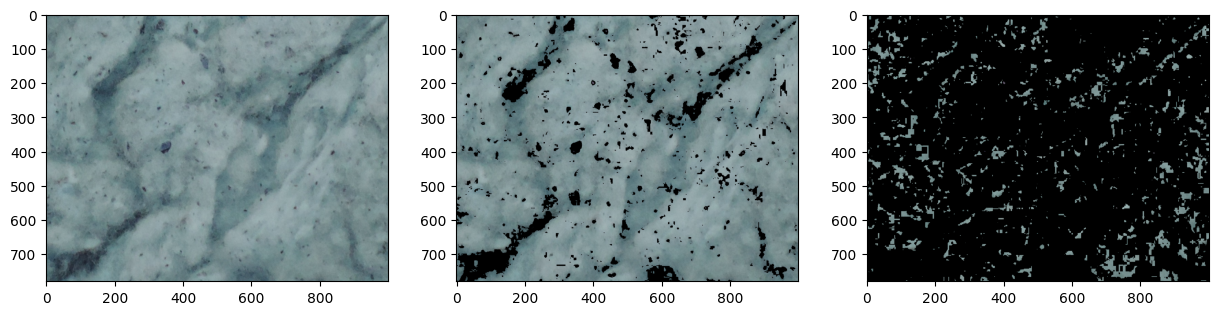

In [5]:
#plotando as imagens 
fig, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(img)
axs[1].imshow(res)
axs[2].imshow(res2)
plt.show

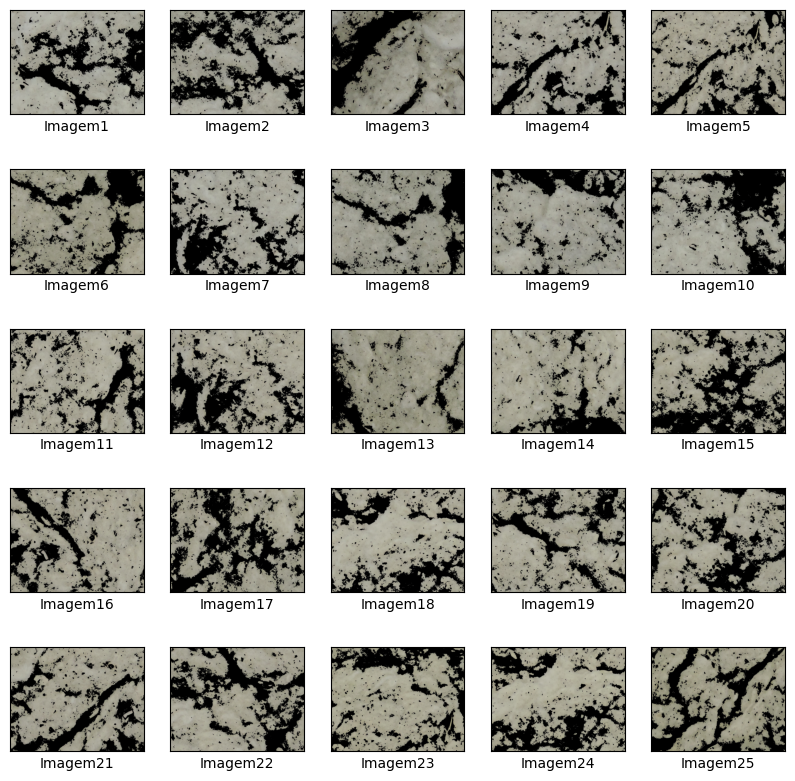

In [8]:
path = "tlinter_otsu/classe1"

images = []
#loading images 
for filename in os.listdir(path):
     img = Image.open(os.path.join(path, filename))
     images.append(img)


plt.figure(figsize= (10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel("Imagem{}".format(i+1))

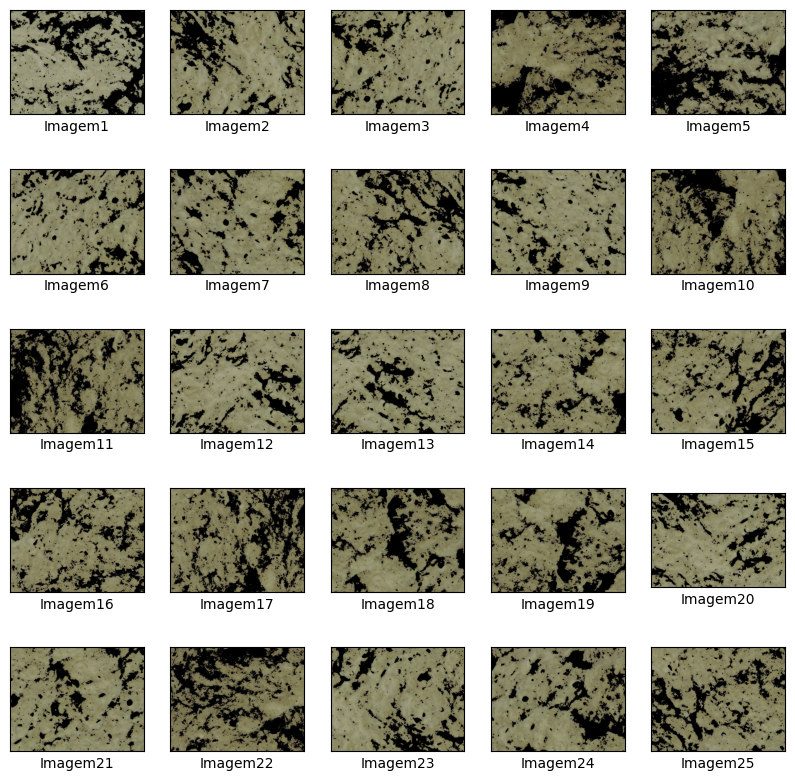

In [10]:
path = "tlinter_otsu/classe5"

images = []
#loading images 
for filename in os.listdir(path):
     img = Image.open(os.path.join(path, filename))
     images.append(img)


plt.figure(figsize= (10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel("Imagem{}".format(i+1))

### Algorítmo de Superresolução EDSRX4 e Limiarização de Otsu

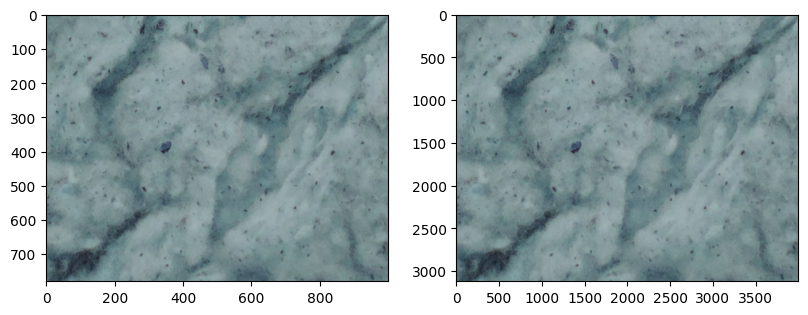

In [7]:
def ssr_edsrx4(imagem):
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    path = "models-srr/EDSR_x4.pb"
    sr.readModel(path)
    sr.setModel("edsr",4)

    result = sr.upsample(imagem)
    
    plt.figure(figsize=(15,10))
    plt.subplot(1,3,1)
    plt.imshow(imagem)
    plt.subplot(1,3,2)
    plt.imshow(result)

    plt.show()

ssr_edsrx4(img)

In [11]:

altura, largura, canais = img.shape  #salvando as dimensoes da imagem normal
altura2, largura2, canais2 = result.shape #imagem com super resolução
print(f'Dimensões da imagem: {largura}x{altura} pixels')
print(f'Dimensões da imagem com super-resolução: {largura2}x{altura2} pixels')


Dimensões da imagem: 1000x780 pixels
Dimensões da imagem com super-resolução: 4000x3120 pixels


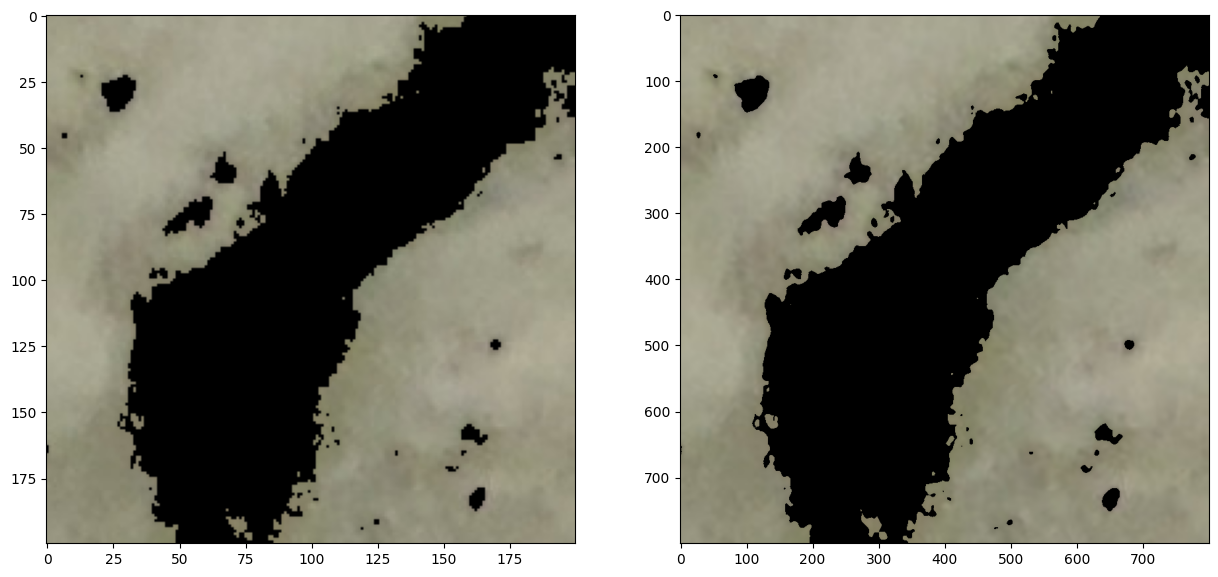

In [9]:
#retirando uma parte menor da imagem para observar
x, y, largura, altura = 100, 100, 200, 200
roi = img[y:y+altura, x:x+largura]

#aplicando o algoritmo de super resoluçao na parte menor
sr = cv2.dnn_superres.DnnSuperResImpl_create()
path = "models-srr/EDSR_x4.pb"
sr.readModel(path)
sr.setModel("edsr",4)

edsrx4 = sr.upsample(roi)

#convertendo imagem para escala de cinza para otsu
roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
edsrx4_gray = cv2.cvtColor(edsrx4, cv2.COLOR_BGR2GRAY)

# aplicar o método de otsu para encontrar o valor de limiar
ret_roi, thr_roi = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_result, thr_result = cv2.threshold(edsrx4_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#aplicando a mascara com valores de limiar
res_roi = cv2.bitwise_and(roi, roi, mask = thr_roi)
res_edsrx4 = cv2.bitwise_and(edsrx4, edsrx4, mask = thr_result)


plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(res_roi[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(res_edsrx4[:,:,::-1])

plt.show()

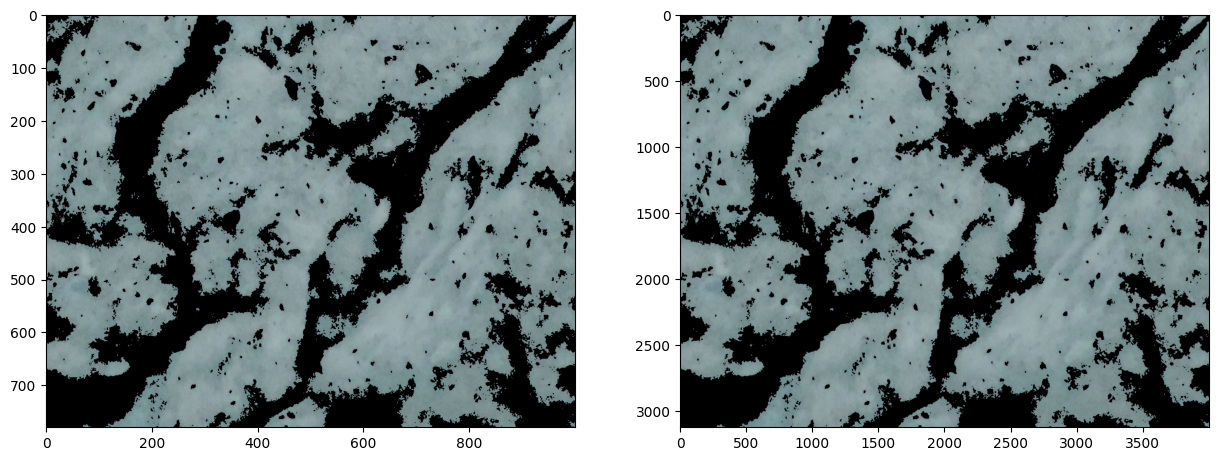

In [10]:
#aplicando o algoritmo de super resoluçao na parte menor
sr = cv2.dnn_superres.DnnSuperResImpl_create()
path = "models-srr/EDSR_x4.pb"
sr.readModel(path)
sr.setModel("edsr",4)

result = sr.upsample(img)

#convertendo imagem para escala de cinza para otsu
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
result_gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

# aplicar o método de otsu para encontrar o valor de limiar
ret_roi, thr_roi = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret_result, thr_result = cv2.threshold(result_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#aplicando a mascara com valores de limiar
res_img = cv2.bitwise_and(img, img, mask = thr_roi)
res_result = cv2.bitwise_and(result, result, mask = thr_result)


plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(res_img)
plt.subplot(1,2,2)
plt.imshow(res_result)


In [12]:
#contando pixels com valor zerados
pixels_roi = cv2.countNonZero(thr_roi)
pixels_result = cv2.countNonZero(thr_result)

total_roi = img.shape[0] * result.shape[1]
total_result = result.shape[0] * result.shape[1]

removed_pixels_roi = 100 - (pixels_roi / total_roi) * 100
removed_pixels_result = 100 - (pixels_result / total_result) * 100

print(pixels_roi)
print(pixels_result)

print(total_roi)
print(total_result)

print(removed_pixels_roi)
print(removed_pixels_result)

541321
8661588
3120000
12480000
82.64996794871794
30.596249999999998


In [47]:
def hist_rgb(image):
    b, g, r = cv2.split(image)
    
    hist_r = cv2.calcHist([r], [0], None)
    hist_g = cv2.calcHist([g], [0], None)
    hist_b = cv2.calcHist([b], [0], None)

In [15]:

input = 'tlinter'
output = 'tlinter_otsu'

files = os.listdir(input)

#cria uma pasta de saida caso ela nao exista
if not os.path.exists(output):
    os.makedirs(output)

#loop para rodar as imagens na pasta
for file in files:
    if file.endswith('.jpg'):  #verificando arquivos que terminam com extensai .jpeg
        img_path = os.path.join(input, file)       
        img= cv2.imread(img_path)    #lendo a imagem
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        res = cv2.bitwise_and(img, img, mask=thresh) #aplicando a mascara de imagem vetorizada
        
        output_path = os.path.join(output, file) #Acessar a pasta final de output
        
        cv2.imwrite(output_path,res)

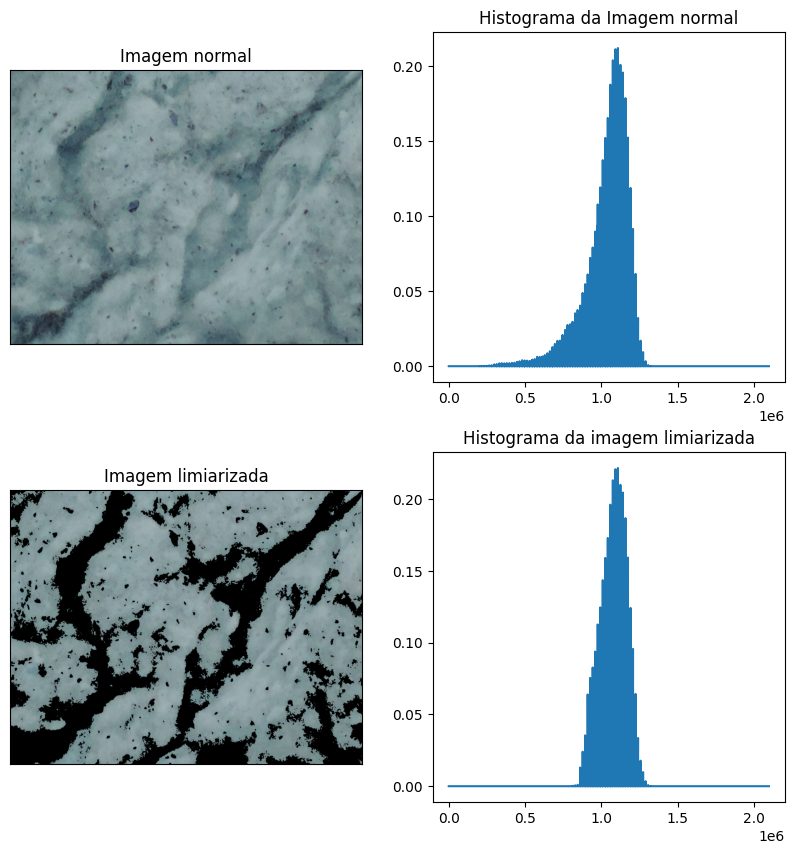

In [17]:
hist1 = cv2.calcHist([img], [0,1,2], None, [128,128,128], [1,256, 1,256, 1,256])
hist2 = cv2.calcHist([res_img], [0,1,2], None, [128,128,128], [1,256, 1,256, 1,256])

hist1 = cv2.normalize(hist1, hist1).flatten()
hist2 = cv2.normalize(hist2, hist2).flatten()


fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0, 0].imshow(img)
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[0, 0].set_title('Imagem normal')

axs[1, 0].imshow(res_img)
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
axs[1, 0].set_title('Imagem limiarizada')

# Plote os histogramas na segunda coluna da grade
axs[0, 1].plot(hist1)
axs[0, 1].set_title('Histograma da Imagem normal')

axs[1, 1].plot(hist2)
axs[1, 1].set_title('Histograma da imagem limiarizada')

plt.show()

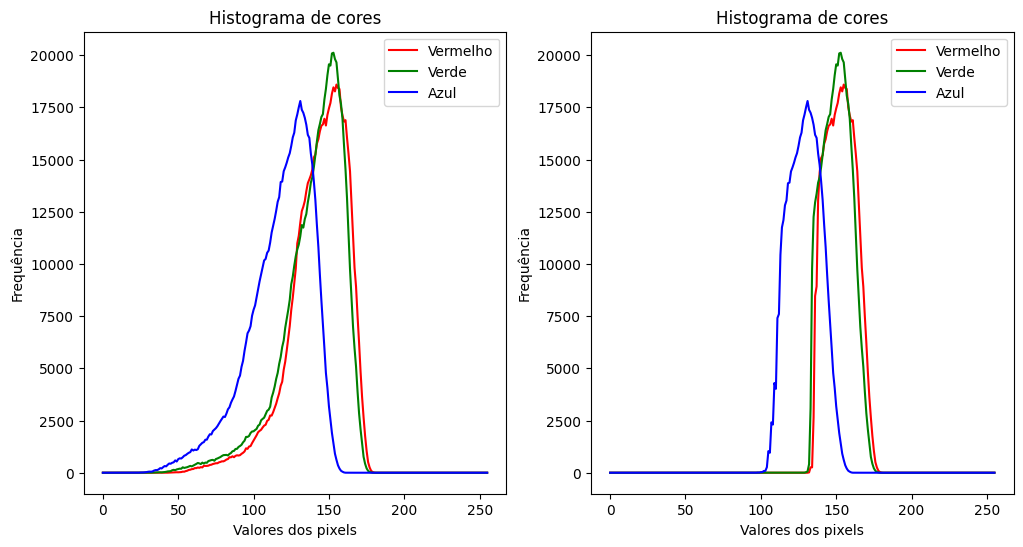

In [49]:
#carregando as imagens
b1, g1, r1 = cv2.split(img)
b2, g2, r2 = cv2.split(res_img)


hist_r1 = cv2.calcHist([r1], [0], None, [256], [1,256])
hist_g1 = cv2.calcHist([g1], [0], None, [256], [1,256])
hist_b1 = cv2.calcHist([b1], [0], None, [256], [1,256])

hist_r2 = cv2.calcHist([r2], [0], None, [256], [1,256])
hist_g2 = cv2.calcHist([g2], [0], None, [256], [1,256])
hist_b2 = cv2.calcHist([b2], [0], None, [256], [1,256])

# hist_r1 = cv2.calcHist([r1], [0], None, [256], [0,256])
# hist_g1 = cv2.calcHist([g1], [0], None, [256], [0,256])
# hist_b1 = cv2.calcHist([b1], [0], None, [256], [0,256])

#plotando
fig, axs = plt.subplots(1,2, figsize= (12,6))

axs[0].plot(hist_r1, color='red', label='Vermelho')
axs[0].plot(hist_g1, color='green', label='Verde')
axs[0].plot(hist_b1, color='blue', label='Azul')
axs[0].set_title('Histograma de cores')
axs[0].set_xlabel('Valores dos pixels')
axs[0].set_ylabel('Frequência')
axs[0].legend()

axs[1].plot(hist_r2, color='red', label='Vermelho')
axs[1].plot(hist_g2, color='green', label='Verde')
axs[1].plot(hist_b2, color='blue', label='Azul')
axs[1].set_title('Histograma de cores')
axs[1].set_xlabel('Valores dos pixels')
axs[1].set_ylabel('Frequência')
axs[1].legend()

plt.show()


### Extraindo os dados das imagens

**Buscando os dados de frequência de pixels da imagem e labels**

In [3]:
#extraind os recursos
def extract_features(image):
    #extracao de recursos usando histograma de cores
    hist = cv2.calcHist([image], [0,1,2], None, [128,128,128], [1,256, 1,256, 1,256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

#preparaçao
data = []
labels = []

#iterando as pastas e classes
for class_folder in range(1,6):
    folder_path = f'to_torch/train/classe{class_folder}'
    
    #iterando sobre as imagens
    for file_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file_name)
        #le a imagem
        image = cv2.imread(image_path)
        #extraindo o recurso
        features = extract_features(image)
        #adicionando as classes e recursos a uma lista nos objetos ja existentes de data e labels
        data.append(features)
        labels.append(class_folder)

## Máquina de Suporte de Vetores

In [50]:
#definindo funções com One-vs-Rest
#prediçao usando kernel tricks com parametro RBF
def svm_rbf_ovr(image_data,labels_data):
    x_train, x_test, y_train, y_test = train_test_split(image_data, labels_data, test_size=0.2, random_state=42)
    model_svm_rbf_ovr = svm.SVC(kernel='rbf', 
                            decision_function_shape='ovr',
                            C=1)
    
    model_svm_rbf_ovr.fit(x_train, y_train)
    y_pred_rbf = model_svm_rbf_ovr.predict(x_test)
    
    return r2_score(y_test, y_pred_rbf)
    
#prediçao usando kernel tricks com parametro linear
def svm_linear_ovr(image_data,labels_data):
    x_train, x_test, y_train, y_test = train_test_split(image_data, labels_data, test_size=0.2, random_state=42)
    model_svm_linear_ovr = svm.SVC(kernel='linear', 
                               decision_function_shape='ovr',
                            C=1)
    
    model_svm_linear_ovr.fit(x_train, y_train)
    y_pred_linear =  model_svm_linear_ovr.predict(x_test)
    
    return r2_score(y_test, y_pred_linear)
    
#prediçao usando kernel tricks com parametro polynomial
def svm_poly_ovr(image_data,labels_data):
    x_train, x_test, y_train, y_test = train_test_split(image_data, labels_data, test_size=0.2, random_state=42)
    model_svm_poly_ovr = svm.SVC(kernel='poly', 
                             decision_function_shape='ovr',
                            degree=3, 
                            C=1)
    
    model_svm_poly_ovr.fit(x_train, y_train)
    y_pred_poly = model_svm_poly_ovr.predict(x_test)
    
    return r2_score(y_test, y_pred_poly)
    
#prediçao usando kernel tricks com parametro Sigmoidal
def svm_sigmoid_ovr(image_data,labels_data):
    x_train, x_test, y_train, y_test = train_test_split(image_data, labels_data, test_size=0.2, random_state=42)
    model_svm_sigmoid_ovr = svm.SVC(kernel='sigmoid', 
                                decision_function_shape='ovr',
                            C=1)
    
    model_svm_sigmoid_ovr.fit(x_train, y_train)
    y_pred_sigmoid = model_svm_sigmoid_ovr.predict(x_test)
    
    return r2_score(y_test, y_pred_sigmoid)

In [52]:
#resultados
coef_rbf_ovr = svm_rbf_ovr(data, labels)
coef_linear_ovr = svm_linear_ovr(data, labels)
coef_poly_ovr = svm_poly_ovr(data, labels)
coef_sigmoid_ovr = svm_sigmoid_ovr(data, labels)

df_result_ovr = pd.DataFrame(
    {
        'Kernel Trick': ['RBF', 'Linear', 'Polinomial', 'Sigmoid'],
        'Coeficiente R2':[coef_rbf_ovr, coef_linear_ovr, coef_poly_ovr, coef_sigmoid_ovr]
        })

df_result_ovr

Kernel Trick  Coeficiente R2
0          RBF        0.903846
1       Linear        0.884615
2   Polinomial        0.884615
3      Sigmoid        0.807692

#### Aplicando validação cruzada

In [5]:
svc_model = svm.SVC(kernel='rbf', 
                    decision_function_shape='ovr',
                    C=10,
                    gamma = 1)

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

#svc_model.fit(x_train, y_train)

cross_val = cross_val_score(svc_model, x_train, y_train, cv=5, scoring = 'accuracy')

def intervalos(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*(dv / math.sqrt(len(x_test))))*100, (mean +2 *(dv / math.sqrt(len(x_test))))*100))
    
intervalos(cross_val)

Acurácia média: 92.00%
Intervalo de acurácia: [89.96% ~ 94.04%]


#### Otimização Bayesiana

In [44]:
svc_model = svm.SVC(decision_function_shape='ovo')
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

checkpoint_saver = CheckpointSaver("./checkpoint_svm.pkl", compress= 9) # criando o objetvo de checkpoint

#definindo o espaço de parametros do SVC
space_svc = [
    Categorical(['rbf','poly','sigmoid'], name= 'kernel'),
    Real(0.1, 10, name='C'),
    Real(0.1, 1 ,name= 'gamma')]

@use_named_args(space_svc)
def objective(**params):
    svc_model.set_params(**params)
    
    return -np.mean(cross_val_score(svc_model, x_train, y_train, cv= 5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))
res_gp_svc = gp_minimize(objective, 
                         space_svc, 
                         n_calls=15,
                         callback=[checkpoint_saver],
                         random_state=42)
print( """Melhores parametros:
      kernel= %s,
      c-value= %d,
      gamma= %d"""  % (res_gp_svc.x[0], 
                       res_gp_svc.x[1], 
                       res_gp_svc.x[2]))
    

Melhores parametros:
      kernel= rbf,
      c-value= 4,
      gamma= 0


### Caso queira fazer somente o backup

In [6]:
svc_model = svm.SVC(decision_function_shape='ovr')
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

checkpoint_saver = CheckpointSaver("./checkpoint_svm.pkl", compress= 9) # criando o objetvo de checkpoint

#definindo o espaço de parametros do SVC
space_svc = [
    Categorical(['rbf','poly','sigmoid'], name= 'kernel'),
    Real(0.1, 10, name='C'),
    Real(0.1, 1 ,name= 'gamma')]


@use_named_args(space_svc)
def objective(**params):
    svc_model.set_params(**params)
    
    return -np.mean(cross_val_score(svc_model, x_train, y_train, cv= 5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

In [7]:
res_gp_svc= load('./checkpoint_svm.pkl')
res_gp_svc.fun

0.13

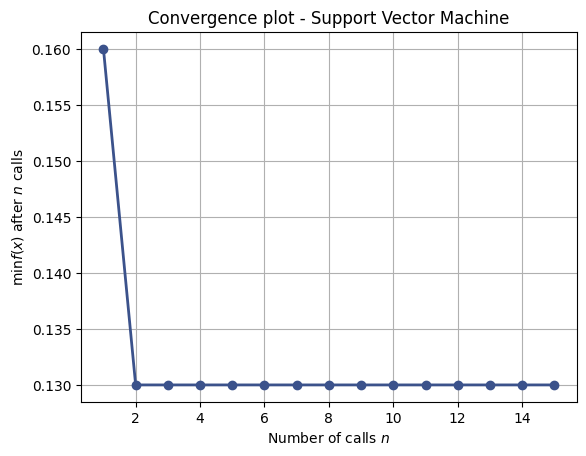

In [35]:
from skopt.plots import plot_convergence

plot_convergence(res_gp_svc)
plt.title("Convergence plot - Support Vector Machine")
plt.show()

#### Utilizando o modelo com os melhores hiperparâmetros selecionados na Otimização Bayesiana

In [58]:
best_svc = svm.SVC(kernel=res_gp_svc.x[0],
                            C= res_gp_svc.x[1],
                            gamma= res_gp_svc.x[2],
                            probability= True)

cv = StratifiedKFold(n_splits= 5, shuffle = True)

cross_val_svc = cross_val_score(best_svc, x_train, y_train, cv= cv, scoring= "accuracy" )

def intervalos(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*(dv / math.sqrt(len(x_test))))*100, (mean +2 *(dv / math.sqrt(len(x_test))))*100))
    
intervalos(cross_val_svc)

Acurácia média: 83.00%
Intervalo de acurácia: [80.96% ~ 85.04%]


#### Analisando e Avaliando o modelo

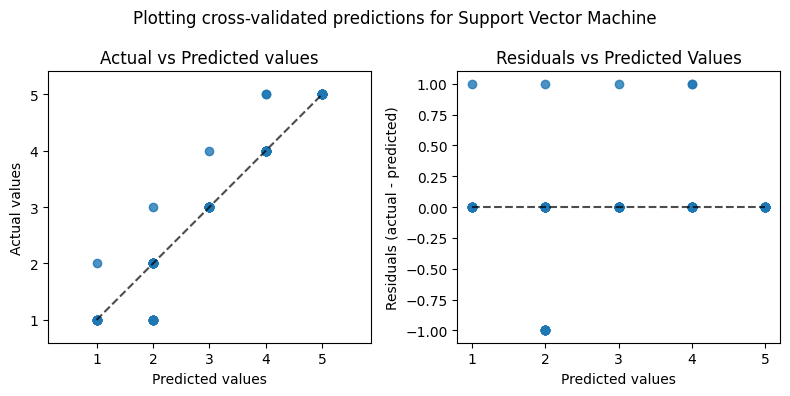

In [59]:
y_pred_svc = cross_val_predict(best_svc,
                           x_train,
                           y_train,
                           cv= cv)

fig, axs = plt.subplots(ncols=2, figsize=(8,4))
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred_svc,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=42,
)
axs[0].set_title("Actual vs Predicted values")
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred = y_pred_svc,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=42,
)
axs[1].set_title("Residuals vs Predicted Values")
fig.suptitle("Plotting cross-validated predictions for Support Vector Machine")
plt.tight_layout()
plt.show()

In [61]:
best_svc.fit(x_train, y_train)

y_pred_svc = best_svc.predict(x_test)

accuracy_svc = accuracy_score(y_test, y_pred)
#podemos classificar a precisão de um modelo comoa proporção de predições corretas de uma categoria em relacao a todas as previsoes feitas dessa categoria
precision_svc = precision_score(y_test, y_pred, average= 'macro')
recall_svc = recall_score(y_test, y_pred, average= 'macro')

print("Acurácia:", accuracy_svc)
print("Precision:", precision_svc)
print("Recall:", recall_svc)

Acurácia: 0.84
Precision: 0.8428571428571429
Recall: 0.8761904761904763


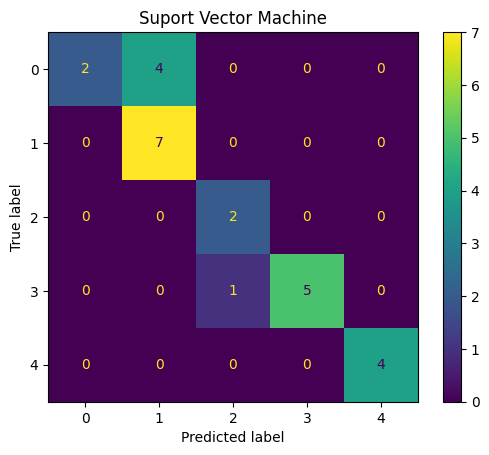

In [42]:
#matriz de confusão
cm = confusion_matrix(y_test, y_pred_svc)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Suport Vector Machine")
plt.show()

In [52]:
count_1 = np.count_nonzero(y_pred_svc == 1)
print("Numero de ocorrencias do numero 1:", count_1)

count_2 = np.count_nonzero(y_pred_svc == 2)
print("Numero de ocorrencias do numero 2:", count_2)

count_3 = np.count_nonzero(y_pred_svc == 3)
print("Numero de ocorrencias do numero 3:", count_3)

count_4 = np.count_nonzero(y_pred_svc == 4)
print("Numero de ocorrencias do numero 4:", count_4)

count_5 = np.count_nonzero(y_pred_svc == 5)
print("Numero de ocorrencias do numero 5:", count_5)

Numero de ocorrencias do numero 1: 2
Numero de ocorrencias do numero 2: 11
Numero de ocorrencias do numero 3: 3
Numero de ocorrencias do numero 4: 5
Numero de ocorrencias do numero 5: 4


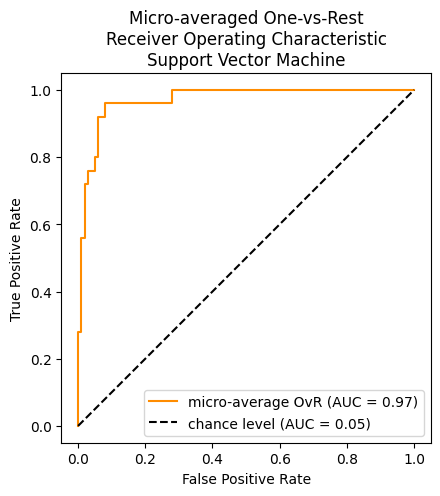

In [62]:
#curva ROC
y_score_svc = best_svc.fit(x_train, y_train).predict_proba(x_test)

label_binarizer_svc = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer_svc.transform(y_test)
y_onehot_test.shape # (n_samples, n_ classes)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score_svc.ravel(),
    name="micro-average OvR",
    color="darkorange"
)
plt.plot([0,1],[0,1],"k--", label="chance level (AUC = 0.05)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic\nSupport Vector Machine")
plt.legend()
plt.show()

## Random Forest

In [6]:
#dividindo os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

#criando o modelo
rf = RandomForestClassifier(max_depth=19, n_estimators= 319)

#treinando o modelo
rf.fit(x_train, y_train)

#testando o modelo
y_pred = rf.predict(x_test)

#calculando a acurácia
rf_r2 = accuracy_score(y_test, y_pred)
print("Acurácia:", rf_r2)


Acurácia: 0.8


#### Validação Cruzada

Multiplicar o desvio padrão por 2 na fórmula do intervalo de acurácia é uma convenção comum para criar um intervalo de confiança de 95%. Esse intervalo é baseado na distribuição normal e é calculado adicionando e subtraindo 2 vezes o desvio padrão da média.

In [7]:
#utilizando a validação cruzada
cross_val = cross_val_score(rf, x_train, y_train, cv=5, scoring = 'accuracy')

#função para calcular a acuracia media da validação cruzada e o intervalode acuracia a 95% de confianca
def intervalos(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*(dv / math.sqrt(len(x_test))))*100, (mean +2 *(dv / math.sqrt(len(x_test))))*100))
    

intervalos(cross_val)

Acurácia média: 83.00%
Intervalo de acurácia: [80.29% ~ 85.71%]


### Otimização Bayesiana

In [10]:

checkpoint_saver = CheckpointSaver("./checkpoint_random_forest.pkl", compress= 9) # ira para dentro da função da minimize

#criando o modelo
rf = RandomForestClassifier()

#criando o espaço para o random forest
space_rf = [
    Integer(1, 20, name="max_depth"),
    Integer(100, 1000, name="n_estimators"),
    Integer(2,10, name="min_samples_split"),
    Integer(1,10, name= "min_samples_leaf"),
    Categorical(['sqrt', 'log2'], name= "max_features")
]

@use_named_args(space_rf)
def objective(**params):
    rf.set_params(**params)
    
    return -np.mean(cross_val_score(rf, x_train, y_train, cv= 5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))    

res_gp_rf = gp_minimize(objective,
                        space_rf, n_calls=15,
                        random_state=42,
                        callback = [checkpoint_saver]) #adicionando o checkpoint criado na otimizacao
print( """Melhores parametros:
      max_depth= %d,
      n_estimator= %d,
      min_sampes_split= %d,
      min_samples_leaf= %d,
      max_features= %s """  % (res_gp_rf.x[0], 
                       res_gp_rf.x[1],
                       res_gp_rf.x[4]))], 
                       res_gp_rf.x[2],
                       res_gp_rf.x[3

Melhores parametros:
      max_depth= 13,
      n_estimator= 650,
      min_sampes_split= 2,
      min_samples_leaf= 1,
      max_features= sqrt 


#### Caso seja necessario carregar somente o checkpoint

In [45]:
#criando o modelo
rf = RandomForestClassifier()

#criando o espaço para o random forest
space_rf = [
    Integer(1, 20, name="max_depth"),
    Integer(100, 1000, name="n_estimators"),
    Integer(2,10, name="min_samples_split"),
    Integer(1,10, name= "min_samples_leaf"),
    Categorical(['sqrt', 'log2'], name= "max_features")
]

@use_named_args(space_rf)
def objective(**params):
    rf.set_params(**params)
    
    return -np.mean(cross_val_score(rf, x_train, y_train, cv= 5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))  

In [47]:
res_gp_rf = load("./checkpoint_random_forest.pkl")

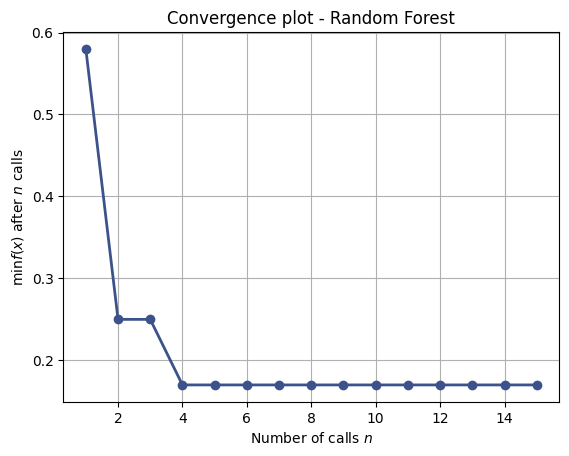

In [36]:
plot_convergence(res_gp_rf)
plt.title("Convergence plot - Random Forest")
plt.show()

### Aplicando o modelo com os hiperparametros otimizados pela otimização Bayesiana

In [53]:
best_rf = RandomForestClassifier(max_depth=res_gp_rf.x[0],
                            n_estimators= res_gp_rf.x[1],
                            min_samples_split= res_gp_rf.x[2],
                            min_samples_leaf= res_gp_rf.x[3],
                            max_features= res_gp_rf.x[4])

cv = StratifiedKFold(n_splits= 5, shuffle = True)

cross_val_rf = cross_val_score(best_rf, x_train, y_train, cv= cv, scoring= "accuracy" )

def intervalos(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*(dv / math.sqrt(len(x_test))))*100, (mean +2 *(dv / math.sqrt(len(x_test))))*100))
    
intervalos(cross_val_rf)

Acurácia média: 84.00%
Intervalo de acurácia: [81.67% ~ 86.33%]


Melhores hiperparametros: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 880}


#### Avaliando e comparando o modelo

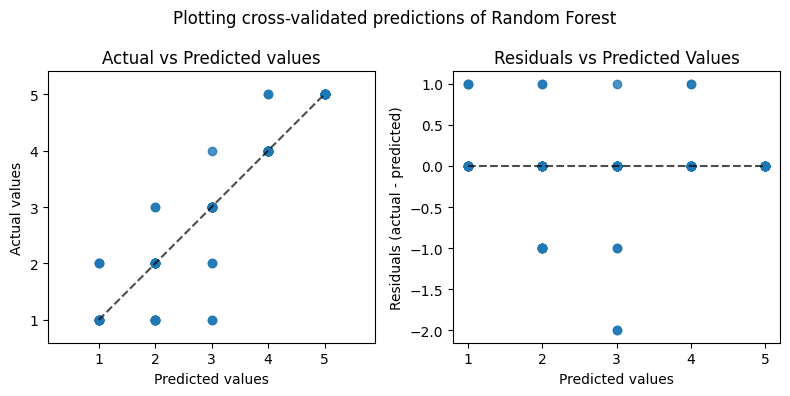

In [49]:
y_pred_rf = cross_val_predict(best_rf,
                           x_train,
                           y_train,
                           cv= cv)

fig, axs = plt.subplots(ncols=2, figsize=(8,4))
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred_rf,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=42,
)
axs[0].set_title("Actual vs Predicted values")
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred = y_pred_rf,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=42,
)
axs[1].set_title("Residuals vs Predicted Values")
fig.suptitle("Plotting cross-validated predictions of Random Forest")
plt.tight_layout()
plt.show()

In [50]:
best_rf.fit(x_train, y_train)

y_pred_rf = best_rf.predict(x_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
#podemos classificar a precisão de um modelo comoa proporção de predições corretas de uma categoria em relacao a todas as previsoes feitas dessa categoria
precision_rf = precision_score(y_test, y_pred_rf, average= 'macro')
recall_rf = recall_score(y_test, y_pred_rf, average= 'macro')

print("Acurácia:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)

Acurácia: 0.88
Precision: 0.888888888888889
Recall: 0.9


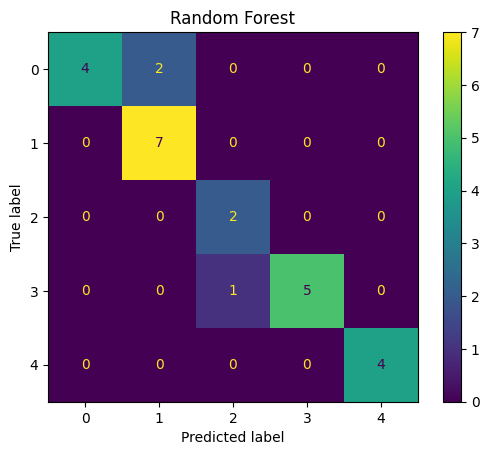

In [51]:
#matriz de confusão
cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Random Forest")
plt.show()

In [18]:
count_1 = np.count_nonzero(y_pred_rf == 1)
print("Numero de ocorrencias do numero 1:", count_1)

count_2 = np.count_nonzero(y_pred_rf == 2)
print("Numero de ocorrencias do numero 2:", count_2)

count_3 = np.count_nonzero(y_pred_rf == 3)
print("Numero de ocorrencias do numero 3:", count_3)

count_4 = np.count_nonzero(y_pred_rf == 4)
print("Numero de ocorrencias do numero 4:", count_4)

count_5 = np.count_nonzero(y_pred_rf == 5)
print("Numero de ocorrencias do numero 5:", count_5)

Numero de ocorrencias do numero 1: 3
Numero de ocorrencias do numero 2: 9
Numero de ocorrencias do numero 3: 4
Numero de ocorrencias do numero 4: 5
Numero de ocorrencias do numero 5: 4


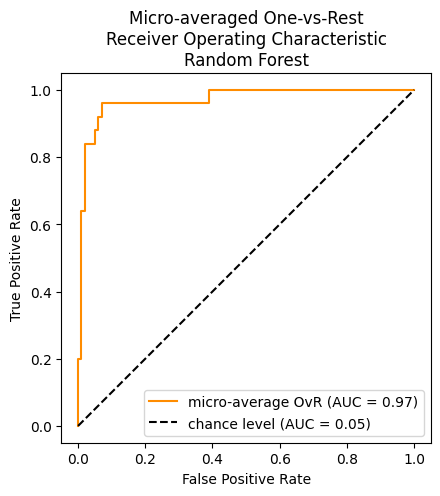

In [52]:
#curva ROC
y_score_rf = best_rf.fit(x_train, y_train).predict_proba(x_test)

label_binarizer_rf = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer_rf.transform(y_test)
y_onehot_test.shape # (n_samples, n_ classes)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score_rf.ravel(),
    name="micro-average OvR",
    color="darkorange"
)
plt.plot([0,1],[0,1],"k--", label="chance level (AUC = 0.05)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic\nRandom Forest")
plt.legend()
plt.show()

In [20]:
print(f"y_score:\n{y_score_rf[0:2,:]}")

y_score:
[[0.48923077 0.40615385 0.08615385 0.01692308 0.00153846]
 [0.20153846 0.57846154 0.20307692 0.01538462 0.00153846]]


In [25]:
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score_rf,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.97


## Regressão Logistica

In [30]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr = lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)
#calculando a acurácia
lr_r2 = accuracy_score(y_test, y_pred)
print("Acurácia:", lr_r2)

Acurácia: 0.76


#### Otimização Bayesiana

In [22]:
from sklearn.linear_model import LogisticRegression

lr= LogisticRegression()

space_lr = [
    Real( 1e-6, 1e+6, prior= 'log-uniform', name='C'), # parametro de regula
    Categorical(['l2', 'none'], name='penalty'),
    Real(1e-6, 1e+2, prior= 'log-uniform', name='tol')
]

checkpoint_saver = CheckpointSaver("./checkpoint_lr.pkl", compress= 9)

@use_named_args(space_lr)
def objective(**params):
    lr.set_params(**params)
    
    return -np.mean(cross_val_score(lr, x_train, y_train, cv= 5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))    

res_gp_lr = gp_minimize(objective,
                        space_lr, n_calls=15,
                        random_state=42,
                        callback = [checkpoint_saver]) #adicionando o checkpoint criado na otimizacao
print( """Melhores parametros:
      C= %d,
      penalty= %d,
      tol= %d"""  % (res_gp_rf.x[0], 
                       res_gp_rf.x[1], 
                       res_gp_rf.x[2]))

/Users/caiomarchiorato/Desktop/visao_comp_algodao/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/caiomarchiorato/Desktop/visao_comp_algodao/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/caiomarchiorato/Desktop/visao_comp_algodao/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/caiomarchiorato/Desktop/visao_comp_algodao/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/caiomarch

Melhores parametros:
      C= 13,
      penalty= 650,
      tol= 2


In [33]:
space_lr = [
    Real( 1e-6, 1e+6, prior= 'log-uniform', name='C'), 
    Categorical(['l2', 'none'], name='penalty'),
    Real(1e-6, 1e+2, prior= 'log-uniform', name='tol')
]

@use_named_args(space_lr)
def objective(**params):
    lr.set_params(**params)
    
    return -np.mean(cross_val_score(lr, x_train, y_train, cv= 5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))    
    
res_gp_lr = load("./checkpoint_lr.pkl")

#### Utilizando a regressão logistica com os valores de parâmetros selecionados pela otimização Bayesiana

In [34]:
best_lr = LogisticRegression(C=res_gp_lr.x[0], 
                        penalty= res_gp_lr.x[1],
                        tol= res_gp_lr.x[2])


cv = StratifiedKFold(n_splits= 5, shuffle = True)

cross_val = cross_val_score(best_lr, x_train, y_train, cv= cv, scoring= "accuracy" )

def intervalos(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*(dv / math.sqrt(len(x_test))))*100, (mean +2 *(dv / math.sqrt(len(x_test))))*100))
    
intervalos(cross_val)


Acurácia média: 85.00%
Intervalo de acurácia: [82.81% ~ 87.19%]


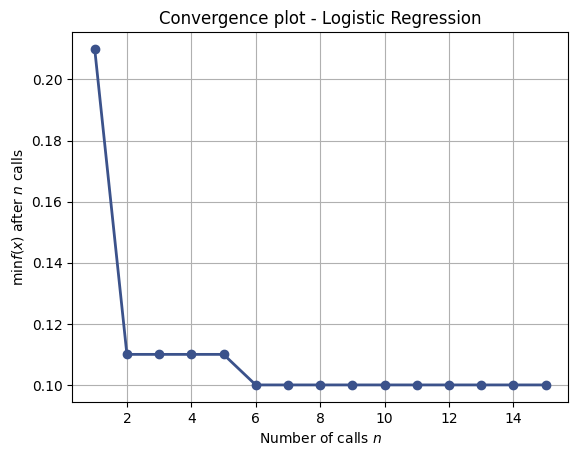

In [37]:

plot_convergence(res_gp_lr)
plt.title("Convergence plot - Logistic Regression")
plt.show()

#### Avaliando e comparando o modelo

In [38]:
best_lr.fit(x_train, y_train)

y_pred = best_lr.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
#podemos classificar a precisão de um modelo comoa proporção de predições corretas de uma categoria em relacao a todas as previsoes feitas dessa categoria
precision = precision_score(y_test, y_pred, average= 'macro')
recall = recall_score(y_test, y_pred, average= 'macro')

print("Acurácia:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Acurácia: 0.84
Precision: 0.8428571428571429
Recall: 0.8761904761904763


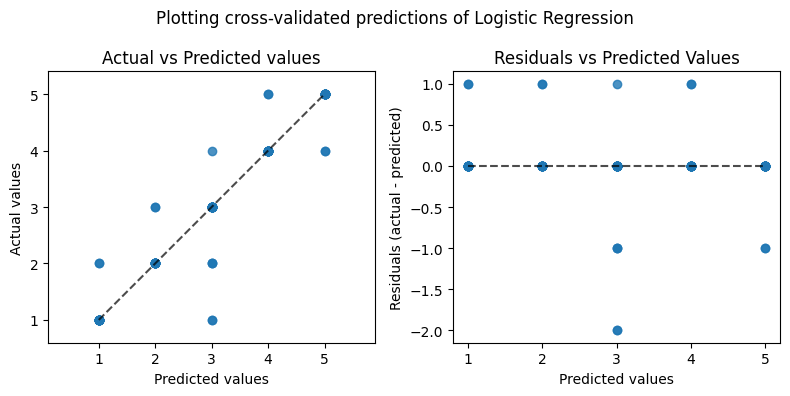

In [55]:
y_pred_lr = cross_val_predict(best_lr,
                           x_train,
                           y_train,
                           cv= cv)

fig, axs = plt.subplots(ncols=2, figsize=(8,4))
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred_lr,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=42,
)
axs[0].set_title("Actual vs Predicted values")
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred = y_pred_lr,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=42,
)
axs[1].set_title("Residuals vs Predicted Values")
fig.suptitle("Plotting cross-validated predictions of Logistic Regression")
plt.tight_layout()
plt.show()

#### Matriz de confusão

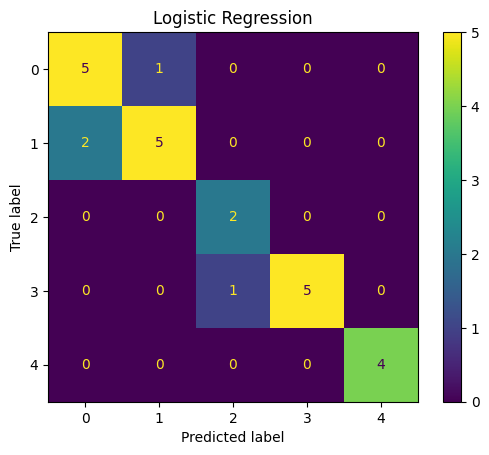

In [56]:

#matriz de confusão
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Logistic Regression")
plt.show()

In [39]:
count_1 = np.count_nonzero(y_pred == 1)
print("Numero de ocorrencias do numero 1:", count_1)

count_2 = np.count_nonzero(y_pred == 2)
print("Numero de ocorrencias do numero 2:", count_2)

count_3 = np.count_nonzero(y_pred == 3)
print("Numero de ocorrencias do numero 3:", count_3)

count_4 = np.count_nonzero(y_pred == 4)
print("Numero de ocorrencias do numero 4:", count_4)

count_5 = np.count_nonzero(y_pred == 5)
print("Numero de ocorrencias do numero 5:", count_5)

Numero de ocorrencias do numero 1: 7
Numero de ocorrencias do numero 2: 6
Numero de ocorrencias do numero 3: 3
Numero de ocorrencias do numero 4: 5
Numero de ocorrencias do numero 5: 4


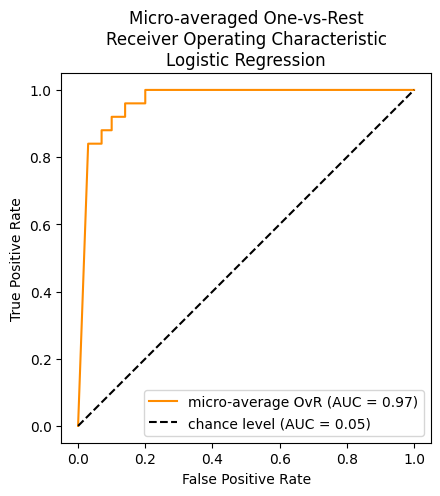

In [60]:
#curva ROC
y_score_lr = best_lr.fit(x_train, y_train).predict_proba(x_test)

label_binarizer_lr = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer_lr.transform(y_test)
y_onehot_test.shape # (n_samples, n_ classes)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score_lr.ravel(),
    name="micro-average OvR",
    color="darkorange"
)
plt.plot([0,1],[0,1],"k--", label="chance level (AUC = 0.05)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic\nLogistic Regression")
plt.legend()
plt.show()



## Redes neurais convolucionais

In [53]:
from tensorflow.keras.utils import load_img

In [54]:

patch = "to_torch/train/"
classes = ["1","2","3","4","5"]
imagens = []
labels = []

for class_folder in range(1,6):
    folder_path = f"to_torch/train/classe{class_folder}"
    
    for file_name in os.listdir(folder_path):
        if file_name == '.DS_Store':
            continue
        else:
            image_path = os.path.join(folder_path, file_name)
            
            image = tf.keras.utils.load_img(image_path,
                                            color_mode= "rgb",
                                            )
            image = tf.keras.utils.img_to_array(image)
            
            imagens.append(image)
            labels.append(int(class_folder))

In [45]:
x_train, x_test, y_train, y_test = train_test_split(imagens, labels, test_size=0.2, random_state=42)

In [50]:
x_tra

In [55]:
print(imagens.shape)

AttributeError: 'list' object has no attribute 'shape'

In [49]:

x_train = np.array(x_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)

ValueError: setting an array element with a sequence.

In [42]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

#x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Carregar e dividir os dados de treinamento e teste
#(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalizar os valores de pixel para o intervalo [0, 1]
x_train, x_test = x_train / 255.0,  x_test / 255.0

# Definir a arquitetura da CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Adicionar camadas densamente conectadas no topo da CNN
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Compilar o modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Treinar o modelo
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Avaliar o modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Acurácia do teste:', test_acc)

# Fazer previsões em novos dados
predictions = model.predict(x_test)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

## Lixo

In [48]:
print("Valor da função no valor minimo do Suport Vector Machine:",res_gp_svc.fun)
print("Valor da função no valor mínimo de Random Forest:", res_gp_rf.fun)

print(res_gp_rf.specs)

NameError: name 'res_gp_svc' is not defined

#tentativa 1 
Melhores parametros:
      kernel= rbf,
      c-value= 10,
      gamma= 1
#tentativa 2
Melhores parametros:
      kernel= rbf,
      c-value= 19,
      gamma= 0

In [47]:
from skopt.plots import plot_convergence

plot_convergence(res_gp_svc)

NameError: name 'res_gp_svc' is not defined

In [46]:
#predição do modelo SVM


TypeError: svm_rbf() got an unexpected keyword argument 'C'

In [ ]:
#tentativa 1 
Melhores parametros:
      kernel= rbf,
      c-value= 10,
      gamma= 1
#tentativa 2
Melhores parametros:
      kernel= rbf,
      c-value= 19,
      gamma= 0